In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys

sys.path.append("../src")

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import pandas as pd
from IPython.display import display

# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from model_selection import modelSelection

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

df_A.sort_values(by=RESPONSE_VARS, ascending=False, inplace=True)
df_B.sort_values(by=RESPONSE_VARS, ascending=False, inplace=True)

print(f"Shape of DBTL cycle 1: {df_A.shape} and DBTL cycle 2: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds


bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of DBTL cycle 1: (27, 10) and DBTL cycle 2: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


#### __PCA__

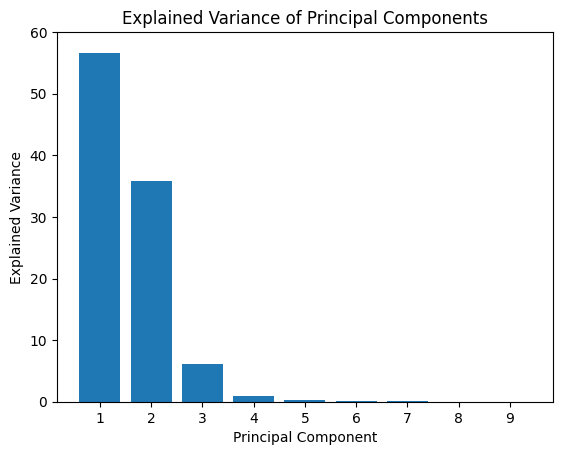

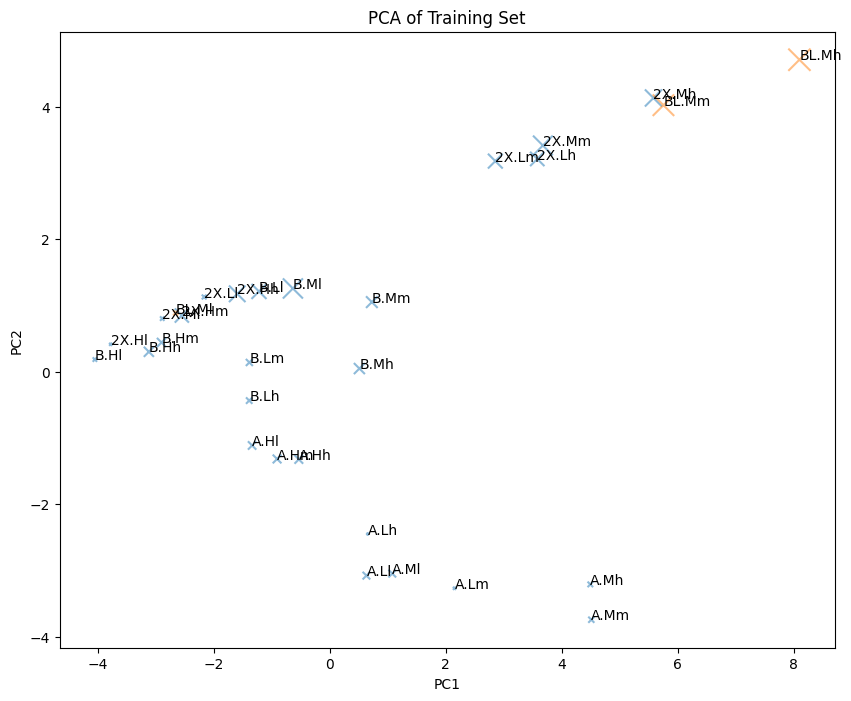

In [4]:
# Perform PCA on the training set
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Get percentage of variance explained by each component
explained_variance = pca.explained_variance_ratio_

plt.bar(range(1, pca.n_components_+1), 100 * explained_variance)
plt.xticks(range(1, pca.n_components_+1))
plt.ylim(0, 60)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("Explained Variance of Principal Components")
plt.show()

# Plot PC1 vs PC2; Label points based on index;
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s=df_A[RESPONSE_VARS].values.ravel() * 2, alpha=0.5, marker='x')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], s=df_B[RESPONSE_VARS].values.ravel() * 2, alpha=0.5, marker='x')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Training Set")
for i, txt in enumerate(df_A.index):
    plt.annotate(txt, (X_train_pca[i, 0], X_train_pca[i, 1]), fontsize=10)
for i, txt in enumerate(df_B.index):
    plt.annotate(txt, (X_test_pca[i, 0], X_test_pca[i, 1]), fontsize=10)
plt.show()


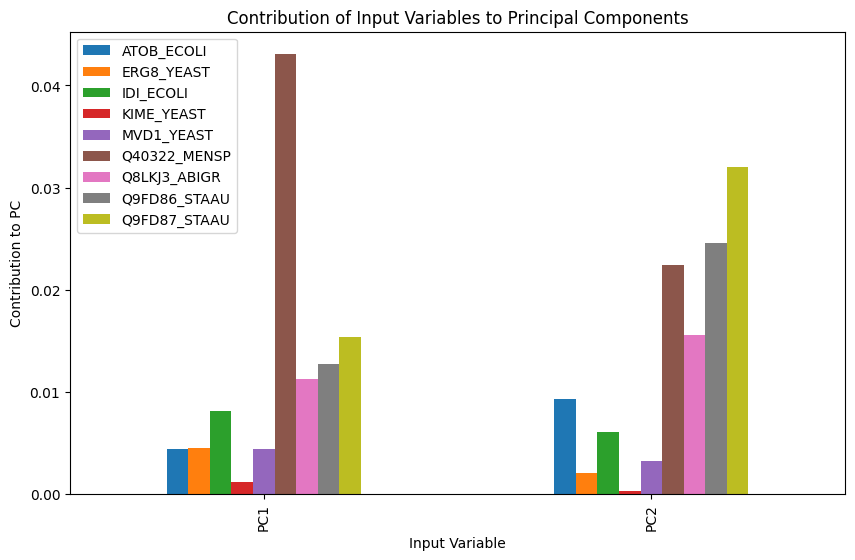

In [3]:
import numpy as np

# Assuming you have already performed PCA and have the PCA object named 'pca'
# Get the loadings of the first PC
loadings = pca.components_


# Calculate the contribution of each input to the first PC
contribution = np.abs(loadings) / np.sum(np.abs(loadings))

contribution_df = pd.DataFrame(contribution, columns=INPUT_VARS)    
contribution_df.index = [f"PC{i+1}" for i in range(pca.n_components_)]
contribution_df = contribution_df.loc[['PC1','PC2']]

# Bar plot of the contribution of each input to the first PC
contribution_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Input Variable')
plt.ylabel('Contribution to PC')
plt.title('Contribution of Input Variables to Principal Components')
plt.show()

In [18]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

# Define the SVR model
svr = SVR()

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.01, 0.001]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(svr, param_grid, n_iter=1000, cv=5, scoring='neg_mean_squared_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Get the best SVR model from RandomizedSearchCV
model = random_search.best_estimator_

Model evaluation (Bootstrap)

In [25]:
def bootstrap(X, y, model: object, n: int = 100):
    mse_values = []
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
        mse_values.append(mean_squared_error(y_test, y_pred))
    return mae_values, mse_values

mae_values, mse_values = bootstrap(X_train, y_train, model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
print(f"Bootstraped Mean(MSE) = {np.mean(mse_values)}")

print(f"Bootstraped std(MAE) = {np.std(mae_values)}")
print(f"Bootstraped std(MSE) = {np.std(mse_values)}")

model.fit(X_train, y_train)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 332.46it/s]


Bootstraped Mean(MAE) = 14.032866066904523
Bootstraped Mean(MSE) = 490.5902354227204
Bootstraped std(MAE) = 4.2909004125927
Bootstraped std(MSE) = 294.5999713698279


SVR(C=1, epsilon=0.001, kernel='linear')

Explainable AI 

  0%|          | 0/27 [00:00<?, ?it/s]

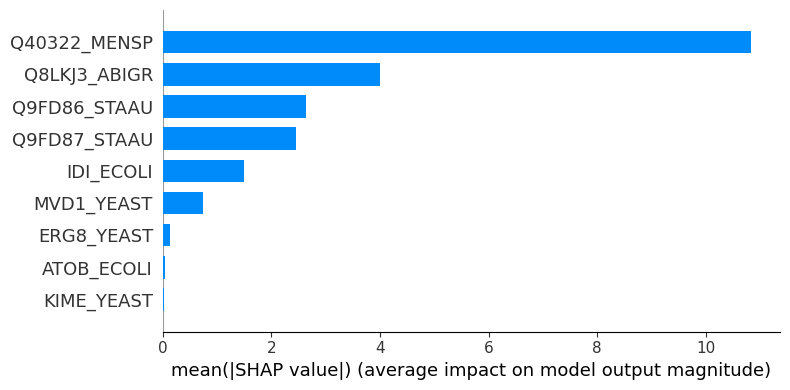

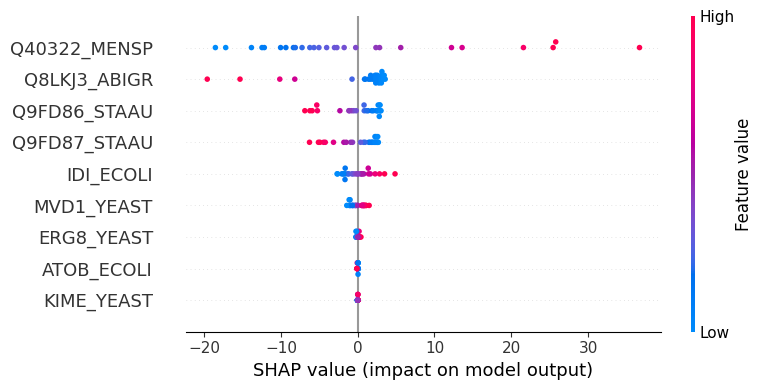

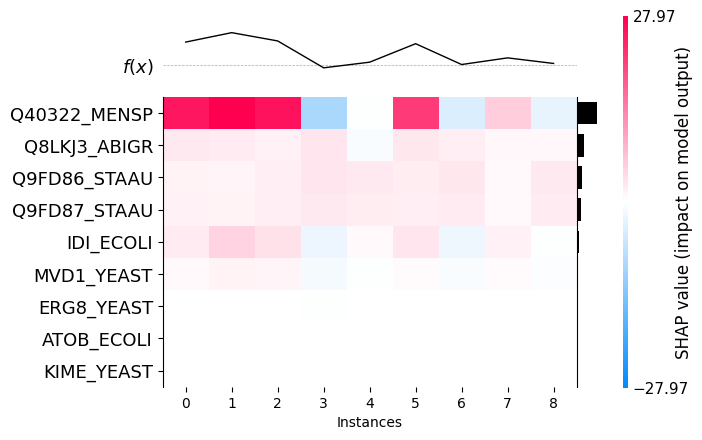

In [27]:
import shap
import matplotlib.pyplot as plt

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


shap_explainer = shap.KernelExplainer(model.predict, df_A[INPUT_VARS])
shap_values = shap_explainer(df_A[INPUT_VARS])
shap_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_df["pred"] = model.predict(df_A[INPUT_VARS])
shap_df["true"] = df_A[RESPONSE_VARS].values.ravel()
shap_df.sort_values(by="pred", ascending=False, inplace=True)
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(8, 4))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(8, 4))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(0), plot_width=6)

In [30]:
# idx=0
# shap.decision_plot(shap_explainer.expected_value, 
#                    shap_df[INPUT_VARS].iloc[idx].values, 
#                    INPUT_VARS)

# print(shap_df[['pred', 'true']].iloc[idx])

In [31]:
# feature = "KIME_YEAST"
# pdplot(df_A[INPUT_VARS], feature, best_xgb, ice=True)
# shap_scatter(feature)

In [32]:
# shap.force_plot(shap_explainer.expected_value, 
#                    shap_df[INPUT_VARS].iloc[2].values, 
#                    features=INPUT_VARS,
#                    matplotlib=True, show=True)

Lime

In [28]:
# Create synthetic dataset from bounds
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(1000)
LB = bounds.T["min"].values.tolist()
UB = bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["Limonene"] = model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("Limonene", ascending=False, inplace=True)
# Drop rows with Limonene < 0
sample_df = sample_df[sample_df["Limonene"] > 0]
X_synth = sample_df[INPUT_VARS]
y_synth = sample_df["Limonene"]

In [34]:
# import lime
# import lime.lime_tabular

# explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=INPUT_VARS,  
#                                                    verbose=True, mode='regression')
                                                   
# i = 22
# exp = explainer.explain_instance(X_train.values[i], final_model.predict)
# exp.show_in_notebook(show_table=True, show_all=True)
# exp.as_list()
# exp.as_pyplot_figure();

#### Sampling

Create new `sampling bounds`, to generate/recommend new strain designs.

In [39]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 9.58
sampling_bounds["Q40322_MENSP"].loc["max"] = 15

sampling_bounds["IDI_ECOLI"].loc["min"] = 2.0
sampling_bounds["IDI_ECOLI"].loc["max"] = 3.0

sampling_bounds["Q9FD87_STAAU"].loc["min"] = 0.2 
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 0.4 

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = 1.27 
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 2.0

sampling_bounds["Q9FD86_STAAU"].loc["min"] = 0.2 
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 0.8 

sampling_bounds["MVD1_YEAST"].loc["min"] = 3.0
sampling_bounds["MVD1_YEAST"].loc["max"] = 4.5

sampling_bounds["ERG8_YEAST"].loc["min"] = 0.5
sampling_bounds["ERG8_YEAST"].loc["max"] = 1.0

sampling_bounds["ATOB_ECOLI"].loc["min"] = 1.0
sampling_bounds["ATOB_ECOLI"].loc["max"] = 2.0

sampling_bounds["KIME_YEAST"].loc["min"] = 1.0
sampling_bounds["KIME_YEAST"].loc["max"] = 2.0


# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100000)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)

#### __AutoEncoder__

In [57]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model

hidden_size = 100
latent_size = 20
input_layer = layers.Input(shape = X_train.shape[1:])
flattened = layers.Flatten()(input_layer)
hidden = layers.Dense(hidden_size, activation = 'relu')(flattened)
latent = layers.Dense(latent_size, activation = 'relu')(hidden)
encoder = Model(inputs = input_layer, outputs = latent, name = 'encoder')

input_layer_decoder = layers.Input(shape = encoder.output.shape)
upsampled = layers.Dense(hidden_size, activation = 'relu')(input_layer_decoder)
upsampled = layers.Dense(encoder.layers[1].output_shape[-1], activation = 'relu')(upsampled)
constructed = layers.Reshape(X_train.shape[1:])(upsampled)
decoder = Model(inputs = input_layer_decoder, outputs = constructed, name= 'decoder')

autoencoder = Model(inputs = encoder.input, outputs = decoder(encoder.output))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())
history = autoencoder.fit(X_train, X_train, epochs=1000, 
                          batch_size=64, validation_split=0.2)


Epoch 1/1000
1/1 [==============================] - 1s 686ms/step - loss: 5.1023 - val_loss: 2.3023
Epoch 2/1000
1/1 [==============================] - 0s 38ms/step - loss: 4.9216 - val_loss: 2.2137
Epoch 3/1000
1/1 [==============================] - 0s 40ms/step - loss: 4.7298 - val_loss: 2.1235
Epoch 4/1000
1/1 [==============================] - 0s 33ms/step - loss: 4.5334 - val_loss: 2.0393
Epoch 5/1000
1/1 [==============================] - 0s 33ms/step - loss: 4.3325 - val_loss: 1.9537
Epoch 6/1000
1/1 [==============================] - 0s 32ms/step - loss: 4.1283 - val_loss: 1.8673
Epoch 7/1000
1/1 [==============================] - 0s 34ms/step - loss: 3.9300 - val_loss: 1.7787
Epoch 8/1000
1/1 [==============================] - 0s 38ms/step - loss: 3.7323 - val_loss: 1.6878
Epoch 9/1000
1/1 [==============================] - 0s 39ms/step - loss: 3.5330 - val_loss: 1.5936
Epoch 10/1000
1/1 [==============================] - 0s 39ms/step - loss: 3.3326 - val_loss: 1.4976
Epoch 11

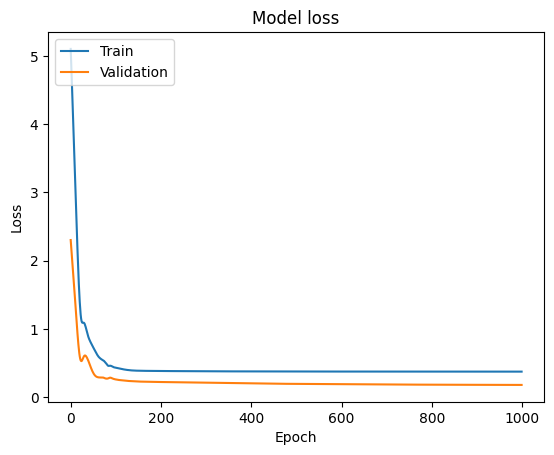

In [58]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [59]:
# Get the latent representation of the training set
X_train_latent = encoder.predict(X_train)
X_test_latent = encoder.predict(X_test)

X_train_latent = pd.DataFrame(X_train_latent)
X_train_latent['Limonene'] = y_train

X_test_latent = pd.DataFrame(X_test_latent)
X_test_latent['Limonene'] = y_test

1/1 [==============================] - 0s 20ms/step


In [61]:
X_test_latent

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Limonene
0,0.0,0.0,2.151010,3.788379,0.0,0.0,5.268309,0.0,7.427964,3.182942,...,1.966189,6.329622,0.0,0.0,2.969824,0.0,0.0,4.417470,4.366787,127.99494
1,0.0,0.0,1.774244,3.126091,0.0,0.0,4.290385,0.0,6.159873,2.604410,...,1.517411,5.387918,0.0,0.0,2.597313,0.0,0.0,3.513400,3.579617,119.81367
2,0.0,0.0,0.212268,0.666585,0.0,0.0,1.145586,0.0,1.594233,0.804470,...,0.286127,1.243085,0.0,0.0,0.677257,0.0,0.0,0.941889,0.896173,6.72018


In [60]:
X_train_latent

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Limonene
0,0.0,0.0,0.815310,1.075942,0.0,0.0,1.736488,0.0,2.551219,0.730584,...,0.822861,2.370828,0.0,0.0,0.954882,0.0,0.0,1.508988,1.451442,104.53655
1,0.0,0.0,0.978870,1.956069,0.0,0.0,2.908040,0.0,5.020337,2.324008,...,1.296357,4.711120,0.0,0.0,2.405628,0.0,0.0,2.921328,2.622442,101.20540
2,0.0,0.0,1.148294,2.305698,0.0,0.0,3.322315,0.0,6.038924,2.900449,...,1.647588,5.724085,0.0,0.0,2.966535,0.0,0.0,3.536847,3.106737,75.39261
3,0.0,0.0,0.470454,0.949633,0.0,0.0,1.306447,0.0,2.054486,0.889692,...,0.552226,1.954789,0.0,0.0,0.858826,0.0,0.0,1.255785,1.172901,71.05431
4,0.0,0.0,0.608415,0.956099,0.0,0.0,1.482366,0.0,2.256533,0.791048,...,0.647287,2.117874,0.0,0.0,0.938990,0.0,0.0,1.330789,1.257342,58.53777
5,0.0,0.0,0.839588,1.742311,0.0,0.0,2.540354,0.0,4.537040,2.154309,...,1.139112,4.326293,0.0,0.0,2.352211,0.0,0.0,2.632524,2.307292,56.97134
6,0.0,0.0,0.987761,1.951336,0.0,0.0,2.656895,0.0,4.891892,2.387011,...,1.391131,4.667343,0.0,0.0,2.390180,0.0,0.0,2.869868,2.546594,53.60310
7,0.0,0.0,0.310205,0.647802,0.0,0.0,0.938135,0.0,1.526690,0.658370,...,0.361934,1.476560,0.0,0.0,0.781612,0.0,0.0,0.896240,0.812348,52.13119
8,0.0,0.0,0.903308,1.045047,0.0,0.0,1.729453,0.0,3.224856,1.177311,...,1.483432,2.756714,0.0,0.0,0.980560,0.0,0.0,2.206973,1.748069,35.29984
9,0.0,0.0,0.844049,0.680926,0.0,0.0,1.178403,0.0,3.026829,1.269338,...,1.992815,2.251336,0.0,0.0,0.491970,0.0,0.0,2.442669,1.600326,31.61376


#### __Counterfactuals (`DiCE`)__

In [38]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=model, backend="sklearn",model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[100, 110],
    permitted_range=bounds_to_dict(sampling_bounds),
    features_to_vary="all",
    # proximity_weight=0.4,
    # diversity_weight=0.8,
    # sparsity_weight=0.4
)

cf_df = e1.cf_examples_list[0].final_cfs_df
# e1.visualize_as_dataframe(show_only_changes=False)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:25<?, ?it/s]


KeyboardInterrupt: 

In [26]:
cf_df = pd.DataFrame()
for i in range(len(e1.cf_examples_list)):
    _ = e1.cf_examples_list[i].final_cfs_df
    # Concatenate the dataframes
    cf_df = pd.concat([cf_df, _], axis=0)

cf_df.sort_values('Limonene', ascending=False, inplace=True)
cf_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,1.0,0.7974,2.6185,1.0,3.0000,9.58,1.27,0.7506,0.3756,42.565155
0,1.0,0.5000,2.0000,1.0,3.8959,9.58,1.27,0.2000,0.3756,39.101215
0,1.0,0.5000,2.0000,1.0,4.0080,9.58,1.27,0.2000,0.3756,39.101215


In [ ]:
df_B

# PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(sample_df[INPUT_VARS][:10])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A", alpha=0.3, s=10)
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B", marker="+")
for i, txt in enumerate(DBTL_B):
    plt.annotate(txt, (trans_df_B[i, 0], trans_df_B[i, 1]))
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC", marker="x")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()

print(df_B["Limonene"].sort_values(ascending=False))

In [ ]:
final_model.predict(df_B[INPUT_VARS])

In [ ]:
from scipy.spatial import distance

# Assuming you have two vectors vec1 and vec2
vec1 = sample_df.iloc[0][INPUT_VARS]
vec2 = df_A.iloc[24][INPUT_VARS]


def calculate_similarity(vec1, vec2):
    # Use the euclidean function from scipy's distance module to calculate the Euclidean distance
    euclidean_distance = distance.euclidean(vec1, vec2) 
    manhattan_distance = distance.cityblock(vec1, vec2)
    cosine_distance = distance.cosine(vec1, vec2)
    pearson_corr = np.corrcoef(vec1, vec2)[0][1]
    print(f"Euclidean distance: {euclidean_distance}")
    print(f'Manhattan distance: {manhattan_distance}')
    print(f'Cosine distance: {cosine_distance}')
    print(f'Pearson correlation: {pearson_corr}')

calculate_similarity(vec1, vec2)